# 3 co-keywords分析

本节主要分析文章关键词之间的关系，首先统计2019年1月到2023年1月之间文章中关键词之间的联系，之后按年细分。  

步骤：  
（1）从原始文章json数据中统计关键词的关系矩阵  
（2）画出2019年1月到2023年1月之间所有数据的关系图  
（3）使用GN算法进行社区划分  
（4）调用（1）中函数，统计每个年份的关键词关系矩阵  
（5）调用（2）（3）中函数进行关系图绘制和社区划分

## 3.1 读取数据，构造关系矩阵

In [170]:
# -*- coding: utf-8 -*-

import networkx as nx
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import pylab
import random
import json
import re

%xmode Verbose
import warnings

# 软件包之间配套时可能会使用过时的接口，把这类告警忽略掉可以让输出信息简练一些
warnings.filterwarnings("ignore", category=DeprecationWarning)

# 把RuntimeWarning忽略掉，不然画图的时候有太多告警了
warnings.filterwarnings("ignore", category=RuntimeWarning)
%matplotlib inline

Exception reporting mode: Verbose


In [171]:
# 读取原始数据
def read_json_data(filepath):
    with open(filepath, encoding='utf-8') as f:
        papers = json.load(f)
    return papers

# 过滤掉非文章的数据以及重复的文章数据
def jsondata_filter(papers, years = (0)):
    papers_list = [] # 存储过滤后的结果
    doi_set = set()
    for paper in papers: 
        title = paper['doi']
        if paper['author_keyword'] != '' and title not in doi_set: # 通过author_keyword是否为空来判断是否是一篇文章
            if years == 0 or int(paper['publication_date'][-4:]) in years: # 过滤年份
                papers_list.append(paper)
                doi_set.add(title)
        else:
            print(paper)
    return papers_list, doi_set
        

In [172]:
papers = read_json_data('./data.json')
filtered_papers, doi_set = jsondata_filter(papers, years=(2021,2022,2023)) # 2019,2020,2021,2022,2023
len(papers),len(filtered_papers) # 统计发现author_keyword为空的文章要么是作者介绍的pdf，要么是书信，所以这部分都该去除

{'article_title': 'IEEE Transactions on Intelligent Vehicles New Associate Editors', 'doi': '10.1109/TIV.2020.2971900', 'publication_date': 'March 2020', 'abstract': 'Presents the introductory editorial for this issue of the publication.', 'start_page': '1', 'end_page': '3', 'pages': '1_3', 'download_count': 354, 'article_content_type': 'Journals', 'publication_title': 'IEEE Transactions on Intelligent Vehicles', 'paper_link': 'https://ieeexplore.ieee.org/document/9012068/', 'pdf_link': 'https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9012068', 'volume': '5', 'issue': '1', 'authors': [{'name': 'Wen-Hua Chen', 'author_links': 'https://ieeexplore.ieee.org/author/37088221762', 'author_affiliation': 'Known'}, {'name': 'Martin Adams', 'author_links': 'https://ieeexplore.ieee.org/author/37088213156', 'author_affiliation': 'Known'}, {'name': 'Lingxi Li', 'author_links': 'https://ieeexplore.ieee.org/author/37088215459', 'author_affiliation': 'Known'}, {'name': 'Simona Onori', 'author_

(454, 218)

如果不加年份设置过滤后的paper总共有434篇；如果设置年份为2019-2023年，过滤后的paper有330篇（4年零1个月）

通过初步的输出，发现几个问题如下：  
（1）keywords中有的单词开头是大写，而我们统计的时候，相同的单词是部分大小写的，也就是说应该统计在一起；  
（2）有的是采用的缩写，而且有的后面用括号标注了缩写，所以如果直接通过字符串对比进行统计显然是不合理的；  
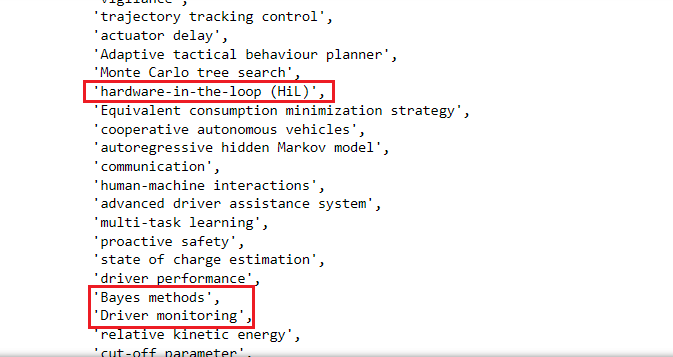
（3）如下图所示，源json文件中有一个乱码，这个为了方便我直接在源文件中删除掉了，在程序中就不用处理了。
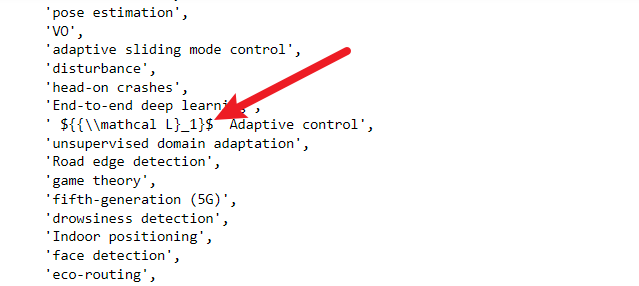

In [173]:
#生成文章属性列表
def gen_papers_attr(papers, attribute):
    papers_attr = set()

    for paper in papers:
        attrs = paper[attribute]
        for item in attrs:
            if isinstance(item, map): # 如果是map （如authors）
                if item[attribute] not in papers_attr:
                    papers_attr.add(item[attribute])
            elif isinstance(item, str): # 如果是str （如author_keyword）
                if item not in papers_attr:
                    papers_attr.add(item)
    return papers_attr


In [174]:
author_keyword = gen_papers_attr(filtered_papers, 'author_keyword')
len(author_keyword)
for item in author_keyword:
    print(item)

visual semantic map-matching
deep neural network (DNN)
routing
smart mining standards
quality-aware fusion
MPC
autonomous racing
vehicular communication
automated vehicles
resource-efficient communication
outage probability
BFT
cyber-physical systems
Connected automated vehicle
agent-based modeling
precision docking
vehicular crowdsensing
Operation emergencies of urban rail transit
Machine learning
open-pit mines
state of charge
prediction
multimodality fusion
mixed-traffic
graphics processing unit (GPU)
Character vector
cut-ins
Federated Vehicular Transformers
radar database
inverse acceleration kinematics
compressed road scene map
artificial potential field
feature sharing
Bibliographic analysis
Deep learning
millimeter wave radar
vehicles interactions
attack/anomaly detection
legal safety
local stability
energy optimization
Automated driving
robotics
ubiquitous operating system
computer vision
Adaptive cruise control
human-machine interactions
sensitivity analysis
real-time scheduli

In [175]:
len(author_keyword)

808

In [176]:
# 对keywords做特殊处理，主要是缩写的合并统计
def author_keyword_process(keywords):
    tmp_set = set()
    # 创建两个map，一个map中<缩写:全称>，另一个map中<全称:缩写>，统计好后在后面按照paper记录填矩阵的时候用来查找。
    abbr_all = {}
    all_abbr = {}
    
    for item in keywords:
        item = item.capitalize() # 变为仅首字母大写
        p = re.compile(r'[(](.*?)[)]', re.S)
        abbr = re.findall(p, item) # 提取缩写，返回一个列表是字符串中所有的缩写，比如['RNN', 'LSTM']
        if len(abbr) != 0:
            item = re.sub(p, '', item).strip() # 删除缩写后的字符串
            item = ' '.join(item.split()) # 先拆分再合并，目的是合并字符串中间多余的空格
#             print(abbr)
#             print(item)
            abbr_all[abbr[0].lower()] = item.lower() # 目前只设置使用abbr[0]，因为一个短语如果中如果有两个缩写，那也无法判断到底用哪一个
            all_abbr[item.lower()] = abbr[0].lower()
            tmp_set.add(abbr[0].lower())
        else:
            tmp_set.add(item)
    
    ans_set = set()
    for item in list(tmp_set):
        if item.lower() in abbr_all.keys():
            ans_set.add(item.upper())
        elif item.lower() in all_abbr.keys():
            ans_set.add(all_abbr[item.lower()].upper())
        else:
            ans_set.add(item)
        
    return list(ans_set), abbr_all, all_abbr

In [177]:
author_keyword, abbr_all, all_abbr = author_keyword_process(author_keyword)
len(author_keyword)

749

In [178]:
# 创建关系矩阵，可以按照不同年份统计
def create_co_keywords_matrix(papers, doi_set, keywords, abbr_all, all_abbr, years = (0)): # year是一个元组，默认所有年份
    # 1. 构造一个空的矩阵，行代表paper，列代表不同的keyword
    matrix_zeros = np.zeros([len(papers), len(keywords)])
    doi_list = list(doi_set)
    table = pd.DataFrame(matrix_zeros, columns=keywords, index=doi_list, dtype=int)
    
    # 2. 填充table
    for paper in papers:
        if years == 0 or int(paper['publication_date'][-4:]) in years:
            author_keywords = paper['author_keyword']
            for item in author_keywords:
                item = item.capitalize() # 变为仅首字母大写
                p = re.compile(r'[(](.*?)[)]', re.S)
                abbr = re.findall(p, item) # 提取缩写，返回一个列表是字符串中所有的缩写，比如['RNN', 'LSTM']
                if len(abbr) != 0:
                    item = re.sub(p, '', item).strip() # 删除缩写后的字符串
                    item = ' '.join(item.split()) # 先拆分再合并，目的是合并字符串中间多余的空格
                    
                    if item.lower() in abbr_all.keys():
                        table.loc[paper['doi'], item.upper()] = 1
                    elif item.lower() in all_abbr.keys():
                        table.loc[paper['doi'], all_abbr[item.lower()].upper()] = 1
                    
                else:
                    if item.lower() in abbr_all.keys():
                        table.loc[paper['doi'], item.upper()] = 1
                    elif item.lower() in all_abbr.keys():
                        table.loc[paper['doi'], all_abbr[item.lower()].upper()] = 1
                    else:
                        table.loc[paper['doi'],item] = 1
                
        
#     table_value = table.values[:]
    print(f'table=\n{table}, shape={table.shape}')
    return table

In [179]:
table = create_co_keywords_matrix(filtered_papers, doi_set, author_keyword, abbr_all, all_abbr) # 这里不设置年份了，因为在上面读取数据的时候就把年份过滤了

table=
                          Inverse acceleration kinematics  \
10.1109/TIV.2022.3160165                                0   
10.1109/TIV.2022.3149891                                0   
10.1109/TIV.2021.3116436                                0   
10.1109/TIV.2020.3046859                                0   
10.1109/TIV.2021.3124208                                0   
...                                                   ...   
10.1109/TIV.2022.3161301                                0   
10.1109/TIV.2022.3152740                                0   
10.1109/TIV.2020.2992086                                0   
10.1109/TIV.2022.3197815                                0   
10.1109/TIV.2021.3119989                                0   

                          Integer ambiguity resolution  Parallel stitching  \
10.1109/TIV.2022.3160165                             0                   0   
10.1109/TIV.2022.3149891                             0                   0   
10.1109/TIV.2021.3116436  

In [180]:
table_value = table.values[:]
keyword_number_of_papers = table_value.sum(axis=0)
sorted(keyword_number_of_papers, reverse=True)

[25,
 21,
 17,
 14,
 13,
 12,
 10,
 8,
 8,
 8,
 8,
 7,
 7,
 6,
 6,
 6,
 6,
 6,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 4,
 4,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 

观察上面的输出发现大概有80%的关键词只出现了一次，而如果把这些全部统计上，后面画出来的关系图会非常密集，导致看不清节点之间的关系，所以下面写一个过滤函数，把出现低于一定频率的关键词直接从统计到的矩阵中删除对应列。

In [181]:
def co_keywords_matrix_frequency_n_filter(table, n): # 过滤出频率大于n的
    table_value = table.values[:]
    frequency = table_value.sum(axis=0)

    bool_arr = np.array(frequency) > n
    
    index_arr = []
    for i in range(len(bool_arr)):
        if not bool_arr[i]:
            index_arr.append(i)
    
    table = table.drop(table.columns[index_arr], axis = 1) # 删除不满足条件的列
    
    return  table

In [182]:
table = co_keywords_matrix_frequency_n_filter(table, 1) #2019-2023:4, 2019-2020:1, 2021-2023:1
table

,MPC,Fault tolerance,Machine learning,Deep learning,Formal verification,Automated driving,Security,Longitudinal control,Autonomous ground vehicles,Motion planning,...,Optimal control,Edge computing,State estimation,Bus,Unmanned autonomous vehicles,Semantic segmentation,Traffic object detection,Autonomous driving,Electric vehicle,LIDAR
10.1109/TIV.2022.3160165,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10.1109/TIV.2022.3149891,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10.1109/TIV.2021.3116436,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10.1109/TIV.2020.3046859,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10.1109/TIV.2021.3124208,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10.1109/TIV.2022.3161301,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
10.1109/TIV.2022.3152740,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
10.1109/TIV.2020.2992086,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10.1109/TIV.2022.3197815,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [183]:
# 这里要重新统计一下author_keyword也就是关键词列表，而不能用上面统计的，因为这时有一些列已经被删除了，这些关键词对应的列也就不存在了
author_keyword = table.columns.values
len(author_keyword), author_keyword

(106,
 array(['MPC', 'Fault tolerance', 'Machine learning', 'Deep learning',
        'Formal verification', 'Automated driving', 'Security',
        'Longitudinal control', 'Autonomous ground vehicles',
        'Motion planning', 'Safety', 'CAVS', 'Control and optimization',
        'Blockchain', 'Cooperative driving', 'Neural network',
        'Connected and autonomous vehicles', 'Decision making',
        'Electric vehicles', 'Connected vehicles',
        'Simultaneous localization and mapping', 'Autonomous automobiles',
        'Driver visual attention', 'Imitation learning',
        'Domain adaptation', 'Cyber-physical systems', 'Collision warning',
        'Prediction', 'Path planning', '3d-lidar', 'Radar', 'V2V',
        'Automotive radar', 'Signals of opportunity',
        'Autonomous vehicles', 'String stability', 'Intelligent vehicle',
        'Neural networks', 'Driving safety', 'Velocity optimization',
        'Reachability analysis', 'Autonomous vehicle', 'Digital twin',
  

In [184]:
# 画图初始化
def draw_graph_init(table, labels):
    table_value = table.values[:]
    matrix_coword = np.dot(np.transpose(table_value),table_value)
    print(f'matrix_coword.shape = {matrix_coword.shape}')
    np.fill_diagonal(matrix_coword, 0) # 主对角线填充0
    # 计算每个节点的度
#     nodes_degree = matrix_coword.sum(axis=0) # 暂时还没用到这个度，先注释了
    
    graph_co_word_matrix = nx.from_numpy_array(matrix_coword)
    print(nx.info(graph_co_word_matrix))
    
    # 为节点添加标签
    coword_labels = nx.get_node_attributes(graph_co_word_matrix, 'labels') # 此时的coword_labels为空{}
    list_labels = list(labels)
    for idx, node in enumerate(graph_co_word_matrix.nodes()): 
#         print("idx=", idx, "; node=", node)
        coword_labels[node] = list_labels[idx]
    graph_co_word_matrix = nx.relabel_nodes(graph_co_word_matrix, coword_labels)
    
    return graph_co_word_matrix
    

## 3.2 绘制整个数据

matrix_coword.shape = (106, 106)
Graph with 106 nodes and 306 edges


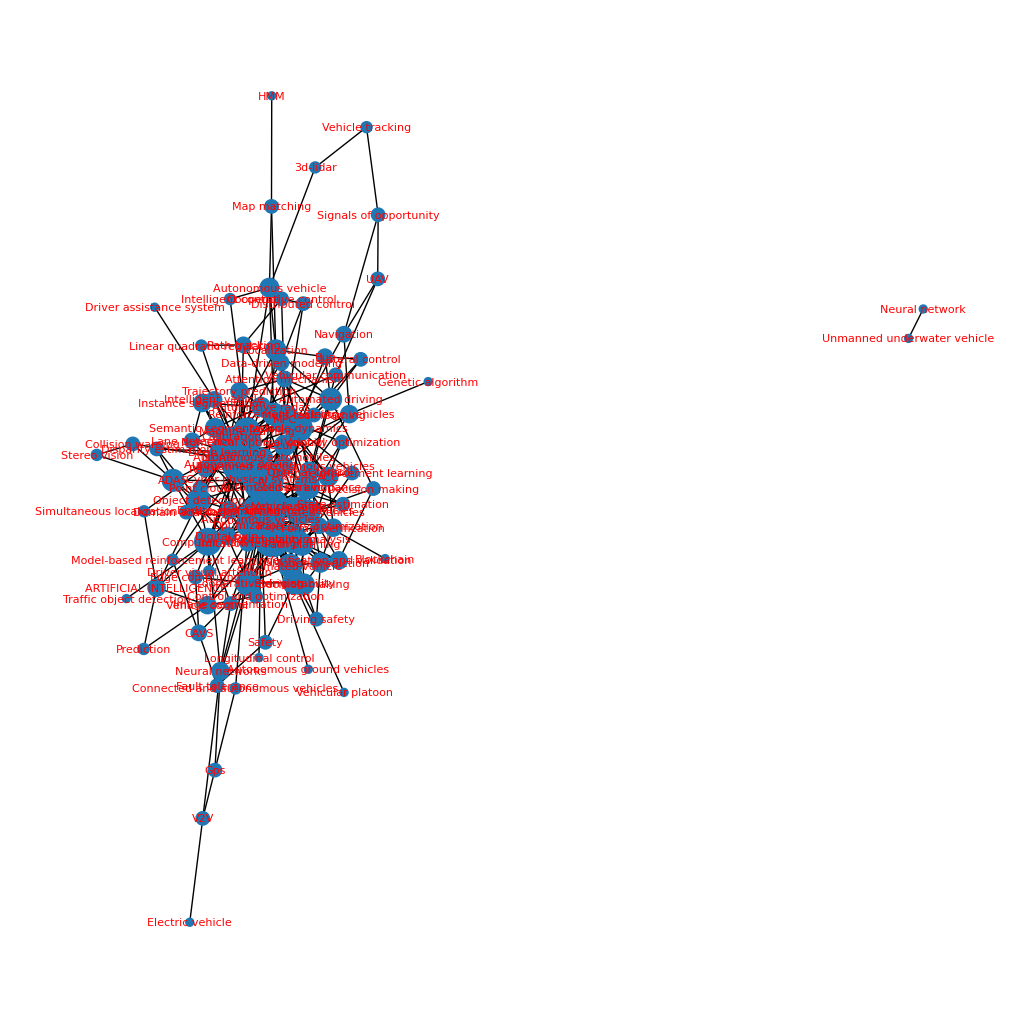

In [185]:
graph_co_word_matrix = draw_graph_init(table, author_keyword)

pos = nx.spring_layout(graph_co_word_matrix)
plt.figure(1, figsize=(10,10),dpi=100)

node_size = [val for (node, val) in graph_co_word_matrix.degree()]
node_size = [3 + 30 * i for i in node_size]

nx.draw(graph_co_word_matrix, pos, node_size=node_size, with_labels=True, font_size=8, font_color="red")
# #nx.draw(graph_co_word_matrix, pos, with_labels=True)
# #nx.draw_networkx_labels(graph_co_word_matrix, pos, labels)
# plt.show()

## 3.3 最大分支绘制

### 3.3.1 不划分社区

联通分支个数：2


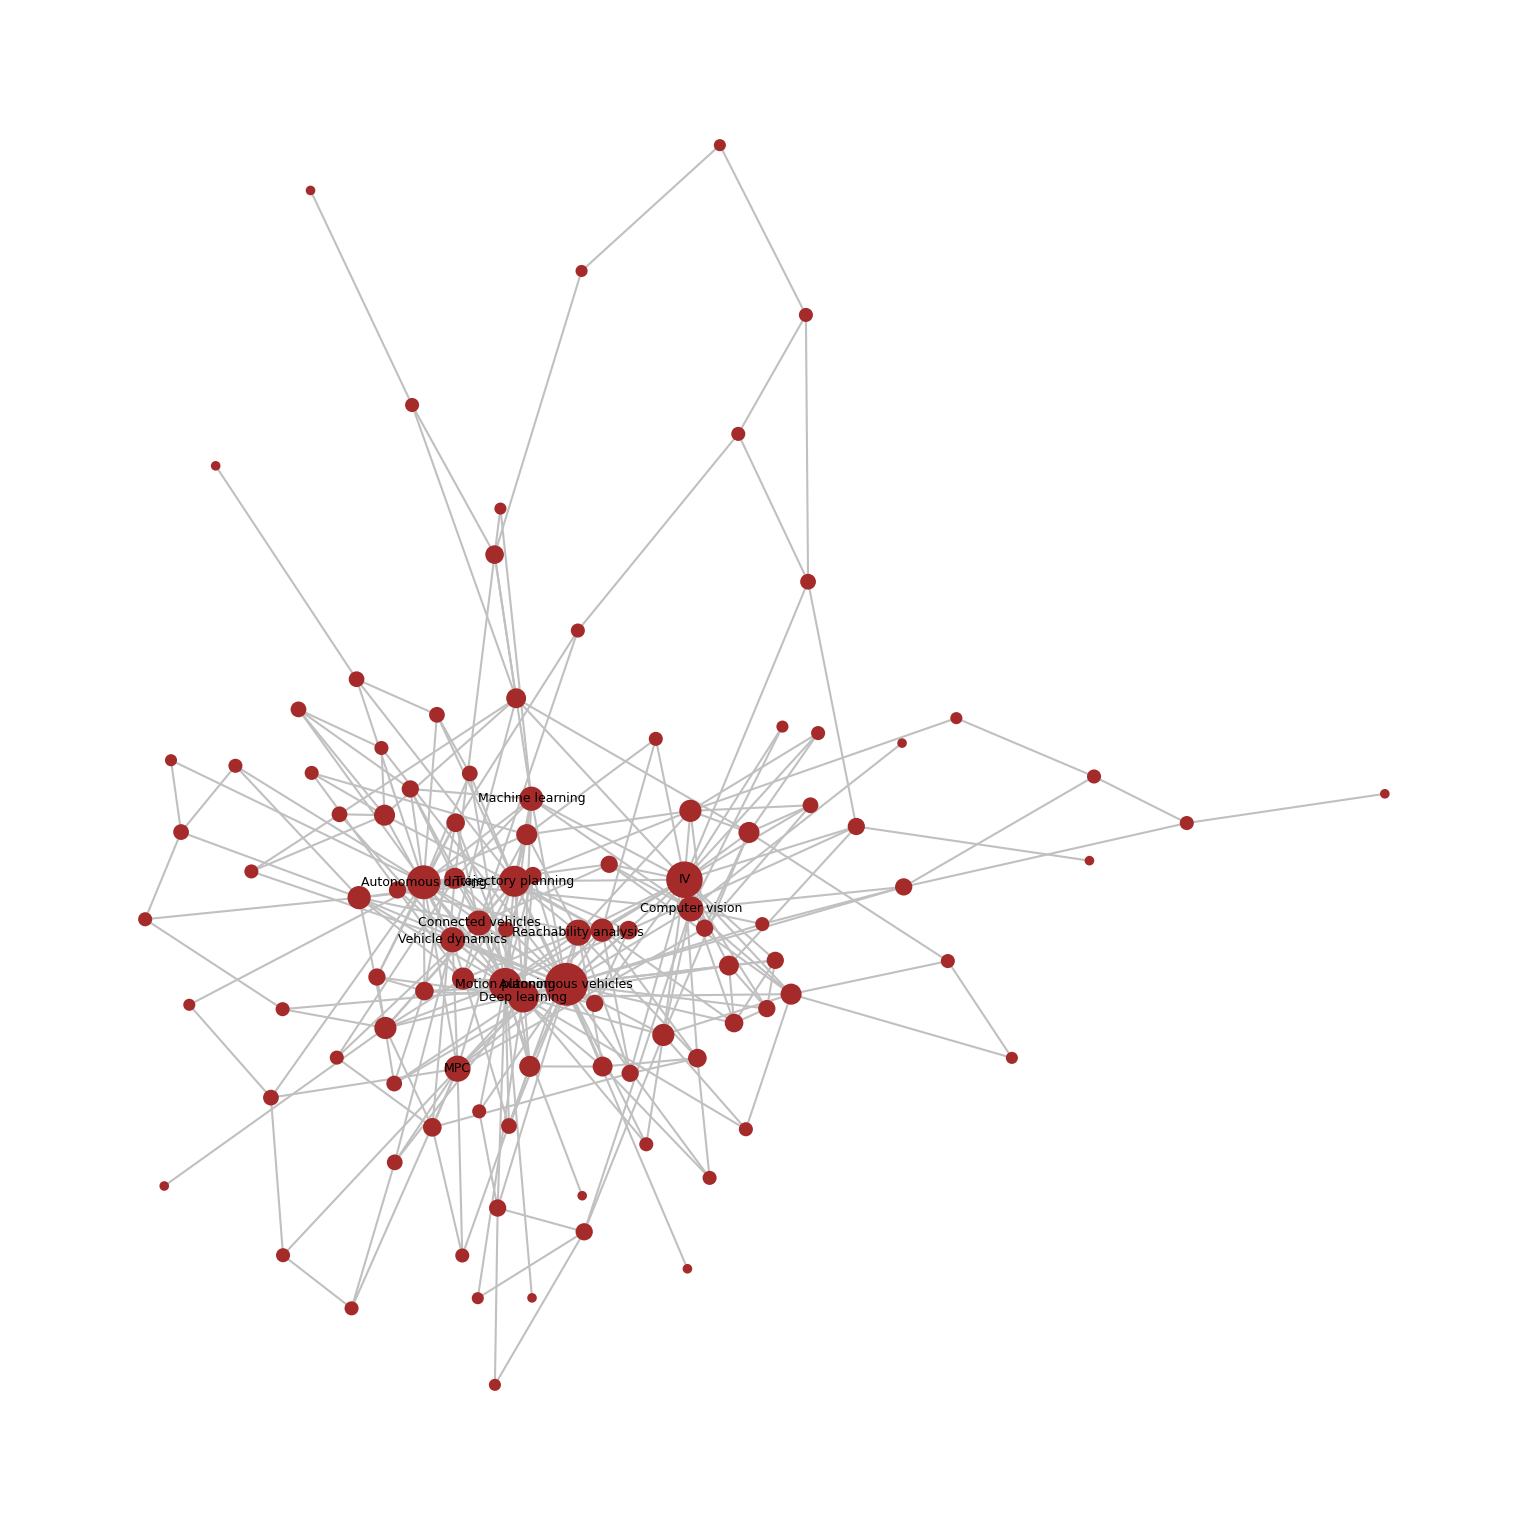

In [186]:
# 分析上面画出来的图，分析联通分支
print(f"联通分支个数：{nx.number_connected_components(graph_co_word_matrix)}")

# 获取 G 中所有的连通子图，然后找出最大的子图
components = nx.connected_components(graph_co_word_matrix)
largest = max(components,key=len)
largest_connected_subgraph = graph_co_word_matrix.subgraph(largest)


pos = nx.spring_layout(graph_co_word_matrix)
plt.figure(1,figsize=(10,10), dpi=150)
node_size = [val for (node, val) in largest_connected_subgraph.degree()]
node_size = [3 + 10 * i for i in node_size]

# 选择一些重要节点显示标签，其他节点不显示，这里设置节点的度大于20时显示标签
labels = {
    n: (n 
        if len(list(nx.all_neighbors(graph_co_word_matrix, n))) > 10
        else '') 
    for n in graph_co_word_matrix.nodes
}
nx.draw(largest_connected_subgraph, pos, node_size=node_size, with_labels=True, labels=labels,
        font_size=6, font_color="black", node_color='brown', edge_color='silver')
plt.show()

### 3.3.2 GN算法社区划分

#### 3.3.2.1 生成划分矩阵，写入文件

In [187]:
%%time
from networkx.algorithms import community

communities_generator = community.girvan_newman(largest_connected_subgraph.copy())
top_level_co_word = sorted(map(sorted, next(communities_generator)))
# top_level_co_word

Wall time: 113 ms


In [188]:
%%time
second_level_co_word = sorted(map(sorted, next(communities_generator)))
second_level_co_word

Wall time: 97.7 ms


[['3d-lidar',
  'Navigation',
  'Signals of opportunity',
  'UAV',
  'Vehicle tracking'],
 ['ACC',
  'ADAS',
  'ARTIFICIAL INTELLIGENCE',
  'Attention mechanism',
  'Automated driving',
  'Automated parking',
  'Automated vehicle',
  'Automated vehicles',
  'Automotive radar',
  'Autonomous automobiles',
  'Autonomous driving',
  'Autonomous ground vehicles',
  'Autonomous vehicle',
  'Autonomous vehicles',
  'Blockchain',
  'Bus',
  'CAVS',
  'Calibration',
  'Collision avoidance',
  'Collision warning',
  'Computer vision',
  'Connected vehicles',
  'Control and optimization',
  'Cooperative control',
  'Cooperative driving',
  'Cyber-physical systems',
  'Data-driven modeling',
  'Decision making',
  'Decision-making',
  'Deep learning',
  'Deep reinforcement learning',
  'Digital twin',
  'Disparity estimation',
  'Distributed control',
  'Domain adaptation',
  'Driver assistance system',
  'Driver visual attention',
  'Driving safety',
  'Edge computing',
  'Electric vehicles',
  

In [189]:
third_level_co_word = sorted(map(sorted, next(communities_generator)))
# third_level_co_word

In [190]:
fourth_level_co_word = sorted(map(sorted, next(communities_generator)))
# fourth_level_co_word

In [191]:
fifth_level_co_word = sorted(map(sorted, next(communities_generator)))
fifth_level_co_word

[['3d-lidar',
  'Navigation',
  'Signals of opportunity',
  'UAV',
  'Vehicle tracking'],
 ['ACC',
  'ADAS',
  'ARTIFICIAL INTELLIGENCE',
  'Automated parking',
  'Automated vehicle',
  'Automated vehicles',
  'Automotive radar',
  'Autonomous automobiles',
  'Autonomous driving',
  'Autonomous ground vehicles',
  'Autonomous vehicles',
  'Blockchain',
  'CAVS',
  'Calibration',
  'Collision avoidance',
  'Collision warning',
  'Computer vision',
  'Connected vehicles',
  'Control and optimization',
  'Cooperative control',
  'Cooperative driving',
  'Cyber-physical systems',
  'Data-driven modeling',
  'Decision making',
  'Decision-making',
  'Deep learning',
  'Deep reinforcement learning',
  'Digital twin',
  'Disparity estimation',
  'Distributed control',
  'Domain adaptation',
  'Driver visual attention',
  'Driving safety',
  'Edge computing',
  'Electric vehicles',
  'End-to-end driving',
  'Fault tolerance',
  'Formal verification',
  'Genetic algorithm',
  'IV',
  'Imitation

In [192]:
sixth_level_co_word = sorted(map(sorted, next(communities_generator)))
sixth_level_co_word

[['3d-lidar',
  'Navigation',
  'Signals of opportunity',
  'UAV',
  'Vehicle tracking'],
 ['ACC',
  'Automated parking',
  'Automated vehicle',
  'Automated vehicles',
  'Automotive radar',
  'Autonomous automobiles',
  'Autonomous driving',
  'Autonomous ground vehicles',
  'Autonomous vehicles',
  'Blockchain',
  'CAVS',
  'Calibration',
  'Collision avoidance',
  'Connected vehicles',
  'Control and optimization',
  'Cooperative control',
  'Cooperative driving',
  'Cyber-physical systems',
  'Data-driven modeling',
  'Decision making',
  'Decision-making',
  'Deep learning',
  'Deep reinforcement learning',
  'Digital twin',
  'Distributed control',
  'Domain adaptation',
  'Driving safety',
  'Edge computing',
  'Electric vehicles',
  'End-to-end driving',
  'Fault tolerance',
  'Formal verification',
  'Genetic algorithm',
  'IV',
  'Imitation learning',
  'Instance segmentation',
  'LIDAR',
  'Lane detection',
  'Linear quadratic regulator',
  'Longitudinal control',
  'MPC',
 

In [193]:
%%time
seventh_level_co_word = sorted(map(sorted, next(communities_generator)))
seventh_level_co_word

Wall time: 65.5 ms


[['3d-lidar',
  'Navigation',
  'Signals of opportunity',
  'UAV',
  'Vehicle tracking'],
 ['ACC',
  'Automated parking',
  'Automated vehicle',
  'Automated vehicles',
  'Automotive radar',
  'Autonomous automobiles',
  'Autonomous driving',
  'Autonomous ground vehicles',
  'Autonomous vehicles',
  'Blockchain',
  'CAVS',
  'Calibration',
  'Collision avoidance',
  'Connected vehicles',
  'Control and optimization',
  'Cooperative control',
  'Cooperative driving',
  'Cyber-physical systems',
  'Data-driven modeling',
  'Decision making',
  'Decision-making',
  'Deep learning',
  'Deep reinforcement learning',
  'Digital twin',
  'Distributed control',
  'Domain adaptation',
  'Driving safety',
  'Edge computing',
  'End-to-end driving',
  'Fault tolerance',
  'Formal verification',
  'IV',
  'Imitation learning',
  'Instance segmentation',
  'LIDAR',
  'Lane detection',
  'Linear quadratic regulator',
  'Longitudinal control',
  'MPC',
  'Machine learning',
  'Model-based reinforcem

In [194]:
%%time
eighth_level_co_word = sorted(map(sorted, next(communities_generator)))
eighth_level_co_word

Wall time: 115 ms


[['3d-lidar',
  'Navigation',
  'Signals of opportunity',
  'UAV',
  'Vehicle tracking'],
 ['ACC',
  'Automated parking',
  'Automated vehicle',
  'Automated vehicles',
  'Automotive radar',
  'Autonomous automobiles',
  'Autonomous driving',
  'Autonomous ground vehicles',
  'Autonomous vehicles',
  'Blockchain',
  'CAVS',
  'Calibration',
  'Collision avoidance',
  'Connected vehicles',
  'Control and optimization',
  'Cooperative driving',
  'Cyber-physical systems',
  'Data-driven modeling',
  'Decision making',
  'Decision-making',
  'Deep learning',
  'Deep reinforcement learning',
  'Digital twin',
  'Distributed control',
  'Domain adaptation',
  'Driving safety',
  'Edge computing',
  'End-to-end driving',
  'Fault tolerance',
  'Formal verification',
  'IV',
  'Imitation learning',
  'Instance segmentation',
  'LIDAR',
  'Lane detection',
  'Longitudinal control',
  'MPC',
  'Machine learning',
  'Model-based reinforcement learning',
  'Motion planning',
  'Motion prediction'

In [195]:
%%time
ninth_level_co_word = sorted(map(sorted, next(communities_generator)))
ninth_level_co_word

Wall time: 213 ms


[['3d-lidar',
  'Navigation',
  'Signals of opportunity',
  'UAV',
  'Vehicle tracking'],
 ['ACC',
  'Automated parking',
  'Automated vehicle',
  'Automotive radar',
  'Autonomous driving',
  'Autonomous ground vehicles',
  'Autonomous vehicles',
  'Blockchain',
  'CAVS',
  'Connected vehicles',
  'Control and optimization',
  'Cooperative driving',
  'Data-driven modeling',
  'Decision-making',
  'Deep learning',
  'Deep reinforcement learning',
  'Digital twin',
  'Domain adaptation',
  'Driving safety',
  'Edge computing',
  'End-to-end driving',
  'Fault tolerance',
  'Imitation learning',
  'Instance segmentation',
  'Lane detection',
  'Longitudinal control',
  'Machine learning',
  'Model-based reinforcement learning',
  'Motion planning',
  'Numerical optimal control',
  'Optimal control',
  'Path planning',
  'Reinforcement learning',
  'Safety',
  'Semantic segmentation',
  'String stability',
  'Trajectory optimization',
  'Trajectory planning',
  'Trajectory prediction',
 

In [196]:
# 因为上面这几个社区划分太慢，所以将划分的结果存入json文件中，下次直接读取

def write_json_data(filepath, data):
    with open(filepath,'w') as f:
         #写入方式1，等价于下面这行
        json.dump(data,f) 
        
# write_json_data('co-keyword_top_level_2019-2023.json', top_level_co_word)
# write_json_data('co-keyword_second_level_2019-2023.json', second_level_co_word)
# write_json_data('co-keyword_third_level_2019-2023.json', third_level_co_word)
# write_json_data('co-keyword_fourth_level_2019-2023.json', fourth_level_co_word)

In [273]:
# write_json_data('co-keyword_fifth_level_2019-2023.json', fifth_level_co_word)
# write_json_data('co-keyword_sixth_level_2019-2023.json', sixth_level_co_word)

In [274]:
# write_json_data('co-keyword_seventh_level_2019-2023.json', seventh_level_co_word)
# write_json_data('co-keyword_eighth_level_2019-2023.json', eighth_level_co_word)
# write_json_data('co-keyword_ninth_level_2019-2023.json', ninth_level_co_word)

#### 3.3.2.2 读取划分矩阵数据

In [2]:
# def read_json_data(filepath):
#     with open(filepath, encoding='utf-8') as f:
#         data = json.load(f)
#     return data

# ninth_level_co_word = read_json_data('co-keyword_ninth_level_2019-2023.json')

In [197]:
largest_subgraph_nodes_degree = list(nx.degree(largest_connected_subgraph))
largest_subgraph_nodes_degree

[('MPC', 13),
 ('Fault tolerance', 3),
 ('Machine learning', 11),
 ('Deep learning', 19),
 ('Formal verification', 5),
 ('Automated driving', 8),
 ('Security', 7),
 ('Longitudinal control', 1),
 ('Autonomous ground vehicles', 1),
 ('Motion planning', 21),
 ('Safety', 3),
 ('CAVS', 4),
 ('Control and optimization', 3),
 ('Blockchain', 1),
 ('Cooperative driving', 10),
 ('Connected and autonomous vehicles', 2),
 ('Decision making', 3),
 ('Electric vehicles', 5),
 ('Connected vehicles', 12),
 ('Simultaneous localization and mapping', 2),
 ('Autonomous automobiles', 5),
 ('Driver visual attention', 2),
 ('Imitation learning', 4),
 ('Domain adaptation', 3),
 ('Cyber-physical systems', 5),
 ('Collision warning', 3),
 ('Prediction', 2),
 ('Path planning', 8),
 ('3d-lidar', 2),
 ('Radar', 4),
 ('V2V', 3),
 ('Automotive radar', 6),
 ('Signals of opportunity', 3),
 ('Autonomous vehicles', 38),
 ('String stability', 9),
 ('Intelligent vehicle', 4),
 ('Neural networks', 5),
 ('Driving safety', 3),

In [198]:
# 对third_level_co_word划分中，每个子集的节点按照度数排序
sub_degree_list = [] # 存放排序结果
for sub_list in ninth_level_co_word:
    sub_degree_map = dict()
    for i in largest_subgraph_nodes_degree:
        if i[0] in sub_list:
            sub_degree_map[i[0]] = i[1]
    tmp = sorted(sub_degree_map.items(), key = lambda x:x[1], reverse=True)
    sub_degree_list.append(tmp)

for item in sub_degree_list:
    for index in range(len(item)):
        if index > 5:
            break
        print(item[index])
    print('==============')

('Navigation', 4)
('Signals of opportunity', 3)
('UAV', 3)
('3d-lidar', 2)
('Vehicle tracking', 2)
('Autonomous vehicles', 38)
('Autonomous driving', 23)
('Motion planning', 21)
('Deep learning', 19)
('Trajectory planning', 19)
('Connected vehicles', 12)
('Computer vision', 12)
('Object detection', 9)
('ADAS', 8)
('ARTIFICIAL INTELLIGENCE', 5)
('Collision warning', 3)
('Disparity estimation', 3)
('Automated driving', 8)
('Localization', 7)
('Attention mechanism', 4)
('Bus', 4)
('Multi-task learning', 3)
('Lateral control', 3)
('IV', 27)
('MPC', 13)
('Reachability analysis', 13)
('Collision avoidance', 10)
('Optimization', 9)
('Automated vehicles', 8)
('Autonomous vehicle', 6)
('Map matching', 3)
('Intelligent control', 2)
('HMM', 1)
('Neural networks', 5)
('V2V', 3)
('Image segmentation', 3)
('Gps', 3)
('Connected and autonomous vehicles', 2)
('Electric vehicle', 1)
('Path tracking', 4)
('Cooperative control', 3)
('Linear quadratic regulator', 2)
('Intelligent vehicle', 4)
('Driver ass

##### 未设置频率过滤之前画图的代码，里面有详细的参数，先留着吧

In [63]:
# 用这个函数，可以最多画4种颜色不同的社区
def plot_communities(G, group_array):
    color_map = []
    for node in G:
        found = False
        for idx, group in enumerate(group_array):
            if node in group:
                found = True
                if idx == 0:
                    color_map.append('#F08A5D')#59BE8D
                elif idx == 1:
                    color_map.append('#3F72AF')#7F8EAE
                elif idx == 2:
                    color_map.append('#6A2C70')#59327A
                elif idx == 3:
                    color_map.append('#AD8B73')
                elif idx == 4:
                    color_map.append('#E7B10A')
                elif idx == 5:
                    color_map.append('#539165')
                elif idx == 6:
                    color_map.append('#413543')
                elif idx == 7:
                    color_map.append('#FE6244')
                elif idx == 8:
                    color_map.append('#EA5455')
                else:
                    color_map.append('#40513B')#146C94
        if found == False:
            color_map.append('silver')

#     nx.draw(G, node_color=color_map, with_labels=True, font_color='white')
#     plt.figure(1,figsize=(10,10), dpi=150)
    seed = random.randint(1, 100)
    print(f'seed = {seed}')
#     pos = nx.spring_layout(G, seed=seed)
    pos = nx.fruchterman_reingold_layout(G, seed=seed)
#     pos = nx.kamada_kawai_layout(G)
    plt.figure(1, figsize=(12,12), dpi=100)
    node_size = [val for (node, val) in G.degree()]
    node_size = [1 + 8 * (i - 1) for i in node_size]
    
    # 选择一些重要节点显示标签，其他节点不显示，这里设置节点的度大于20时显示标签
    labels = {
        n: (n 
            if len(list(nx.all_neighbors(G, n))) > 50 or 'String stability' == n or 'Automated driving' == n or 'Cooperative adaptive cruise control' == n or 'CAVS' == n or 'Obstacle avoidance' == n or 'Gps' == n or 'Attention mechanism' == n or 'Autonomous ground vehicles' == n or 'Intelligent vehicle' == n
            else '') 
        for n in G.nodes
    }
    nx.draw_networkx_nodes(G, pos=pos,
                           node_color=color_map,
                           node_size=node_size,
                           node_shape='o',
                           linewidths=0,
                           alpha=0.6)
    label_options = {"edgecolor": "white", "facecolor": "white", "alpha": 0.5, "boxstyle" : "round, pad=0.2"}
    nx.draw_networkx_labels(G, pos=pos,
                            labels=labels,
                            font_size=10,
                            font_color='black',
                            bbox=label_options,
                            horizontalalignment='left',
                            verticalalignment='center_baseline')
    nx.draw_networkx_edges(G, pos=pos,
                           edge_color='gainsboro',
                           alpha=0.9,
                           width=0.5)
    
    

#     nx.draw(G, pos, node_size=node_size, with_labels=True, labels=labels,
#         font_size=10, font_color="black", node_color=color_map, edge_color='gainsboro', font_family='KaiTi', alpha=0.4)

    plt.axis("off")
    plt.show()

##### 设置频率过滤后的程序

In [226]:
# 用这个函数，可以最多画4种颜色不同的社区
def plot_communities2(G, group_array):
    
#     #2019-2020图中需要删除的一些节点，使图看起来更紧凑一点
#     G = nx.Graph(G)
#     G.remove_node('Semantic segmentation')
#     G.remove_node('Fuzzy logic')
#     G.remove_node('Adaption')
#     G.remove_node('Optimization')
#     G.remove_node('Driver assistance system')
    
    #2021-2023图中需要删除的一些节点
    G = nx.Graph(G)
    G.remove_node('Electric vehicle')
    
    
    color_map = []
    for node in G:
        found = False
        for idx, group in enumerate(group_array):
            if node in group:
                found = True
                if idx == 0:
                    color_map.append('#3F72AF')#59BE8D
                elif idx == 1:
                    color_map.append('#F08A5D')#7F8EAE
                elif idx == 2:
                    color_map.append('#6A2C70')#59327A
                elif idx == 3:
                    color_map.append('#AD8B73')
                elif idx == 4:
                    color_map.append('#E7B10A')
                elif idx == 5:
                    color_map.append('#539165')
                elif idx == 6:
                    color_map.append('#413543')
                elif idx == 7:
                    color_map.append('#FF0000')
                elif idx == 8:
                    color_map.append('#B22222')
                else:
                    color_map.append('#40513B')#146C94
        if found == False:
            color_map.append('silver')

#     nx.draw(G, node_color=color_map, with_labels=True, font_color='white')
#     plt.figure(1,figsize=(10,10), dpi=150)
    seed = random.randint(1, 100)
    print(f'seed = {seed}')
    pos = nx.spring_layout(G, seed=17) # 2021-2023
#     pos = nx.spring_layout(G, seed=86) # 2019-2023
#     pos = nx.spring_layout(G, seed=65) # 2019-2020
#     pos = nx.fruchterman_reingold_layout(G, seed=seed)
#     pos = nx.kamada_kawai_layout(G)
    plt.figure(1, figsize=(8,8), dpi=100) # 2019-2023, 2019-2020, 2021-2023
    node_size = [val for (node, val) in G.degree()]
#     node_size = [1 + 40 * (i) for i in node_size] # 2019-2020
#     node_size = [1 + 30 * (i) for i in node_size] # 2019-2023
    node_size = [1 + 30 * (i) for i in node_size] # 2021-2023
    
    # 选择一些重要节点显示标签，其他节点不显示，这里设置节点的度大于20时显示标签
    add_another_labels = [
# 2019-2023
#         'ACC',
#         'Automated driving',
#         'LIDAR',
#         'Connected vehicles',
#         'EVS',
#         'Optimization',
#         'Reinforcement learning',
#         'Semantic segmentation',
#         'Trajectory prediction'
#     ]
    
# 2021-2023
        'Navigation',
'Computer vision',
'Automated driving',
'Autonomous vehicle',
'Neural networks',
'Path tracking',
'Electric vehicles'
    ]

# 2019-2020
#     'Automation',
# 'Model predictive control',
# 'Trajectory planning',
# 'Lidar',
# 'Decision making',
# 'Obstacle avoidance']


# 2019-2023:11
# 2019-2020:6
# 2021-2023:19


    labels = {
        n: (n 
            if len(list(nx.all_neighbors(G, n))) > 19 or n in add_another_labels
            else '') 
        for n in G.nodes
    }
    nx.draw_networkx_nodes(G, pos=pos,
                           node_color=color_map,
                           node_size=node_size,
                           node_shape='o',
                           linewidths=1,
                           edgecolors='black',
                           alpha=0.7)
    label_options = {"edgecolor": "white", "facecolor": "white", "alpha": 0.5, "boxstyle" : "round, pad=0.2"}
    nx.draw_networkx_labels(G, pos=pos,
                            labels=labels,
                            font_size=8,
                            font_color='black',
                            bbox=label_options,
                            horizontalalignment='left',
                            verticalalignment='center_baseline',
                            font_family='Times New Roman')
    nx.draw_networkx_edges(G, pos=pos,
                           edge_color='black',
                           alpha=0.3,
                           width=0.5)
    
    

#     nx.draw(G, pos, node_size=node_size, with_labels=True, labels=labels,
#         font_size=10, font_color="black", node_color=color_map, edge_color='gainsboro', font_family='KaiTi', alpha=0.4)

    plt.axis("off")
#     plt.savefig('co-keyword_2019-2023.pdf')
#     plt.savefig('co-keyword_2019-2020.pdf')
    plt.savefig('co-keyword_2021-2023.pdf')
    plt.show()

seed = 98


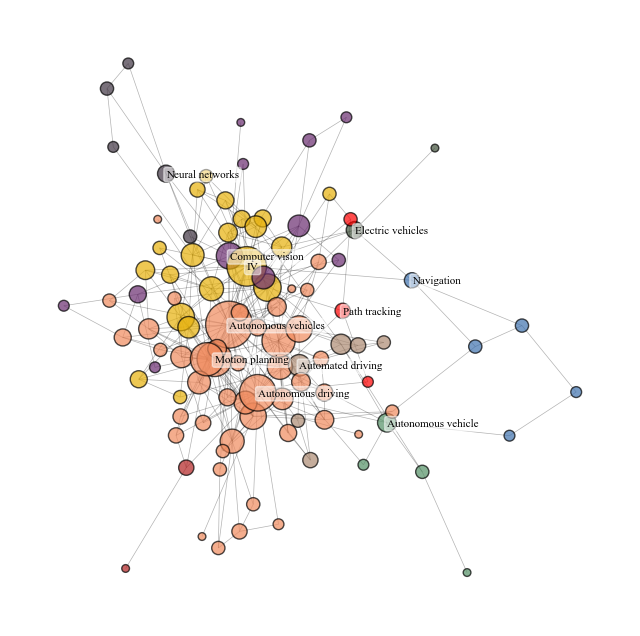

In [227]:
plot_communities2(largest_connected_subgraph, ninth_level_co_word)